<h3>Installing the required libraries </h3>

In [1]:
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
from pydub import AudioSegment
import json
import pandas as pd

C:\Users\deepu\AppData\Roaming\Python\Python38\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


<h3>Visualising the waveform of one of the audio files</h3>

Text(0, 0.5, 'Amplitude')

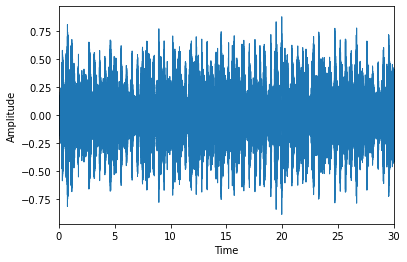

In [5]:
#visualising the waveform of a file
file = 'D:\\Music_Genre_Classifier\\genres\\blues\\blues.00000.wav'
signal, sr = librosa.load(file,sr=22050) #sr*T = 22050*30
librosa.display.waveplot(signal,sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")

<h3>Short time fourier transform to obtain the spectrogram</h3>

In [18]:
#short time fourier transform

num_samples = 2048
hop_length = 512

stft = librosa.core.stft(signal,hop_length = hop_length, n_fft = num_samples)

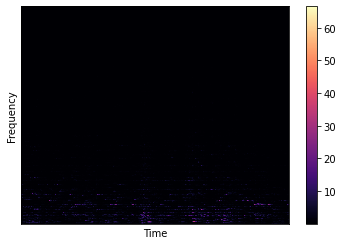

In [19]:
#obtaining the spectrogram
spectrogram = np.abs(stft)
librosa.display.specshow(spectrogram,sr = sr,hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

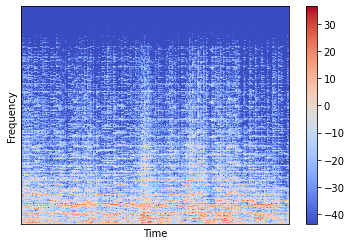

In [20]:
#most frequencies here have very low amplitude
#hence we apply logarithm to increase the amplitude
log_spectrogram = librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(log_spectrogram,sr = sr,hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

<h3>MFCC of the .wav file </h3>

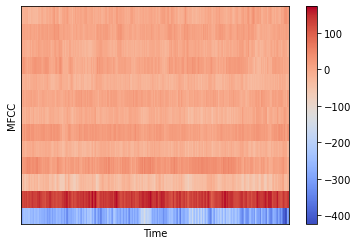

In [21]:
#extracting the MFCC
MFCC = librosa.feature.mfcc(signal,n_fft = num_samples, hop_length=hop_length, n_mfcc= 13)
librosa.display.specshow(MFCC,sr = sr,hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

In [2]:
genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

<h3> Creating empty directories to store the split audio </h3>

In [3]:
#making empty directories for each genre
os.makedirs('split_audio')
for g in genres:
    path_aud =os.path.join('./split_audio',f'{g}')
    os.makedirs(path_aud)

<h3> Splitting the 30 second audio file to obtain more data </h3>

In [4]:
for g in genres:
    j=0
    #print(f"{g}")
    for filename in os.listdir(os.path.join('D:\\Music_Genre_Classifier\\genres',f"{g}")):
        song  =  os.path.join(f'D:\\Music_Genre_Classifier\\genres\\{g}',f'{filename}')
        #print(song)
        if song == 'D:\\Music_Genre_Classifier\\genres\\jazz\\jazz.00054.wav':
            continue
        j = j+1
        for w in range(0,10): 
            t1 = 3*(w)*1000
            t2 = 3*(w+1)*1000
            newAudio = AudioSegment.from_wav(song)
            new = newAudio[t1:t2]
            new.export(f'split_audio\\{g}\\{g+str(j)+str(w)}.wav', format="wav")
    print(j)  

98
98
98
98
98
97
98
98
98
98


<h3> Extracting the Features </h3>

In [5]:
def extract_features(song):
    data,sample_rate = librosa.load(song)
    result = np.array([])
    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally
    
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    return result

<h4> Traversing through the files and extracting the features </h4>

In [6]:
X,y = [], []
i=0
for g in genres:
    #print(f"{g}")
    for filename in os.listdir(os.path.join('D:\\Music_Genre_Classifier\\split_audio',f"{g}")):
        song  =  os.path.join(f'D:\\Music_Genre_Classifier\\split_audio\\{g}',f'{filename}')
        feature = extract_features(song)
        X.append(feature)
        y.append(genres[i]) 
    i=i+1

In [7]:
print(len(X), len(y))

9790 9790


<h3>Saving the features in a CSV file </h3>

In [8]:
import pandas as pd
df = pd.DataFrame(X)
df['labels']=y

In [9]:
df.to_csv('features.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.081851,0.579009,0.624623,0.686781,0.470759,0.544221,0.525484,0.491052,0.537119,0.494352,...,-4.694758,8.414781,-7.225895,-2.849641,-3.241225,0.721986,-5.043308,-0.237658,0.130405,blues
1,0.089660,0.557974,0.636934,0.690804,0.438685,0.367912,0.458473,0.358982,0.519043,0.491877,...,-4.626411,-8.754211,-1.608822,-2.981052,-4.482487,-0.801767,1.847051,-12.404111,0.100803,blues
2,0.075988,0.672756,0.621099,0.679568,0.489572,0.417867,0.386514,0.445422,0.568462,0.556923,...,-0.742809,0.015820,1.282320,-1.849125,-3.800669,-5.045403,3.043768,-8.812757,0.076853,blues
3,0.092150,0.392838,0.419019,0.599155,0.451601,0.406347,0.465561,0.543726,0.743239,0.474039,...,-7.858192,-7.901232,-9.209595,-3.425711,-0.244007,5.384075,2.308877,-0.559395,0.094578,blues
4,0.070737,0.402847,0.426587,0.766400,0.419973,0.381662,0.459160,0.458815,0.701034,0.446694,...,-7.805186,-5.480179,-9.119368,-3.698500,-0.747889,0.671222,-1.238274,-1.038241,0.106024,blues
